In [40]:
import pandas as pd
from river import compose
from river import linear_model
from river import metrics
from river import preprocessing
from river import stream
from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.pyplot as plt
import numpy as np
from meteostat import Point, Hourly
import matplotlib.dates as mdates



In [41]:
# Load the data
df = pd.read_csv('residential4_grid_import_export_weather_fixed_timestamps.csv')

#update grid import to be difranced
df['DE_KN_residential4_grid_import'] = df['DE_KN_residential4_grid_import'].diff()
print(df['DE_KN_residential4_grid_import'])

# set first value to 0
df['DE_KN_residential4_grid_import'].iloc[0] = 0

# Convert the 'utc_timestamp' column to datetime
df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])
print(df['utc_timestamp'])

# Extract day of the week and hour of the day
df['day_of_week'] = df['utc_timestamp'].dt.dayofweek
df['hour_of_day'] = df['utc_timestamp'].dt.hour
df['month'] = df['utc_timestamp'].dt.month

# Define the features and the target
features = ['hour_of_day','day_of_week','month', 'temp','season_Summer','season_Winter','season_Spring','season_Autumn','holiday']

target = 'DE_KN_residential4_grid_import'

# Create a feature selector
selector = SelectKBest(score_func=f_regression, k=5)

# Fit the selector to the data
selector.fit(df[features], df[target])

# Get the selected features
mask = selector.get_support()
selected_features = [f for f, m in zip(features, mask) if m]

print(f'Selected features: {selected_features}')

df.set_index('utc_timestamp', inplace=True)


0             NaN
1        0.039682
2        0.030990
3        0.075048
4        0.175761
           ...   
81430    0.295898
81431    0.279297
81432    0.145508
81433    0.219727
81434    0.209961
Name: DE_KN_residential4_grid_import, Length: 81435, dtype: float64
0       2015-10-10 16:30:00
1       2015-10-10 16:45:00
2       2015-10-10 17:00:00
3       2015-10-10 17:15:00
4       2015-10-10 17:30:00
                ...        
81430   2018-02-04 22:00:00
81431   2018-02-04 22:15:00
81432   2018-02-04 22:30:00
81433   2018-02-04 22:45:00
81434   2018-02-04 23:00:00
Name: utc_timestamp, Length: 81435, dtype: datetime64[ns]
Selected features: ['hour_of_day', 'temp', 'season_Summer', 'season_Winter', 'season_Spring']


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [42]:
#df = df.rolling(window=20).mean()

#drop na values
df = df.dropna()

from river import compose
from river import metrics
from river import preprocessing
from river import stream
from river import neighbors
import matplotlib.pyplot as plt
import concurrent.futures

# Define the range of neighbors to test
n_neighbors_values = range(10, 11)

# Prepare a dictionary to store the actual and predicted values for each model
results = {n_neighbors: {"actuals": [], "predictions": []} for n_neighbors in n_neighbors_values}

def run_model(n_neighbors):
    # Create a KNN model with the current number of neighbors
    model = compose.Pipeline(
        preprocessing.StandardScaler(),
        neighbors.KNNRegressor(n_neighbors=n_neighbors)
    )

    # Define a metric
    metric = metrics.MAE()

    # Iterate over the data and update the model and the metric
    for xi, yi in stream.iter_pandas(df[selected_features], df[target]):
        y_pred = model.predict_one(xi) if model else None
        model.learn_one(xi, yi)
        if y_pred is not None:
            metric.update(yi, y_pred)
            results[n_neighbors]["actuals"].append(yi)
            results[n_neighbors]["predictions"].append(y_pred)

    print(f'MAE for KNN with {n_neighbors} neighbors: {metric.get()}')

# Use a ThreadPoolExecutor to run each model in its own thread
with concurrent.futures.ThreadPoolExecutor() as executor:
    executor.map(run_model, n_neighbors_values)

# Plot the actual and predicted values for each model
for n_neighbors, result in results.items():
    plt.figure(figsize=(10, 5))
    plt.plot(result["actuals"], label='Actual')
    plt.plot(result["predictions"], label='Predicted')
    plt.ylim(0, 0.5)
    plt.title(f'KNN with {n_neighbors} neighbors')
    plt.legend()
    plt.show()

In [43]:
from river import compose
from river import linear_model
from river import metrics
from river import preprocessing
from river import stream
from river import tree
from river import neighbors
import matplotlib.pyplot as plt

# Define the models
models = {
}

# Prepare a dictionary to store the actual and predicted values for each model
results = {model_name: {"actuals": [], "predictions": []} for model_name in models.keys()}

# Iterate over the models
for model_name, model in models.items():
    # Create a pipeline with preprocessing and the model
    model = compose.Pipeline(
        preprocessing.StandardScaler(),
        model
    )

    # Define a metric
    metric = metrics.MAE()

    # Iterate over the data and update the model and the metric
    for xi, yi in stream.iter_pandas(df[selected_features], df[target]):
        y_pred = model.predict_one(xi) if model else None
        model.learn_one(xi, yi)
        if y_pred is not None:
            metric.update(yi, y_pred)
            results[model_name]["actuals"].append(yi)
            results[model_name]["predictions"].append(y_pred)

    print(f'MAE for {model_name}: {metric.get()}')

# Plot the actual and predicted values for each model
for model_name, result in results.items():
    plt.figure(figsize=(10, 5))
    plt.plot(result["actuals"], label='Actual')
    plt.plot(result["predictions"], label='Predicted')
    plt.ylim(0, 0.5)
    plt.title(model_name)
    plt.legend()
    plt.show()

MAE: 0.179933
MSE: 0.047513


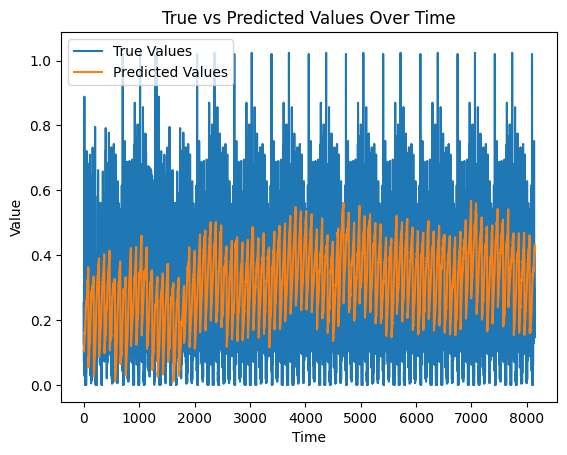

In [44]:
import matplotlib.pyplot as plt
from river import linear_model
from river import metrics
from river import stream
import numpy as np

# Prepare your data
X = df[selected_features].values
y = df[target].values

model = linear_model.PARegressor(
    C=0.01,
    mode=2,
    eps=0.1,
    learn_intercept=False
)
metric = metrics.MAE() + metrics.MSE()

# Prepare lists to store the true and predicted values
y_true = []
y_pred = []

# Use the first 80% of the data for training and the rest for testing
train_size = int(0.9 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train the model
for xi, yi in stream.iter_array(X_train, y_train):
    model.learn_one(xi, yi)

# Test the model
for xi, yi in stream.iter_array(X_test, y_test):
    y_pred_i = model.predict_one(xi)
    metric.update(yi, y_pred_i)

    # Store the true and predicted values
    y_true.append(yi)
    y_pred.append(y_pred_i)

print(metric)

# Plot the true vs predicted values
plt.plot(y_true, label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('True vs Predicted Values Over Time')
plt.legend()
plt.show()

In [ ]:
steps_ahead = 4 * 24 * 365  # Number of 15-minute intervals in a year

# Create a model
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    neighbors.KNNRegressor()
)

# Define a metric
metric = metrics.MAE()

# Prepare lists to store the actual and predicted values
actuals = []
predictions = []

# Iterate over the data and update the model and the metric
for xi, yi in stream.iter_pandas(df[selected_features], df[target]):
    y_pred = model.predict_one(xi) if model else None
    model.learn_one(xi, yi)
    if y_pred is not None:
        metric.update(yi, y_pred)
        actuals.append(yi)
        predictions.append(y_pred)

print(f'MAE: {metric.get()}')


# Create Point for Brussels
location = Point(50.8503, 4.3517)

# Get the last date in your existing data
last_date = df.index.max()

# Calculate the start and end dates based on the steps_ahead variable
start = last_date + pd.Timedelta(minutes=15)
end = start + pd.Timedelta(minutes=15*steps_ahead)


# Get hourly data for the specified period
weather_data = Hourly(location, start, end)
weather_data = weather_data.fetch()

# Interpolate to every 15 minutes
weather_data = weather_data.resample('15min').interpolate()

# Add a column for weather type
weather_data['weather_type'] = weather_data['prcp']
#print(weather_data)
# Select only the temperature and weather type columns
weather_data = weather_data[['temp']]
print(weather_data.index.min())
#print(weather_data)
# Calculate the start and end dates for the predictions
start_date = pd.Timestamp(weather_data.index.min())
print(start_date)
print(weather_data.index.max())
end_date = weather_data.index.max()
print(end_date)
dates = pd.date_range(start_date, end_date, freq='15min')
print(dates)


predictions_next_year = []
for date in dates:
    # Get the weather data for this date

    temp = weather_data.loc[date, 'temp']
    xi = {
        'hour_of_day': date.hour,
        'day_of_week': date.dayofweek,
        'month': date.month,
        'temp': temp,  # Use the actual temperature
        'season_Summer': 1 if date.month in [6, 7, 8] else 0,
        'season_Winter': 1 if date.month in [12, 1, 2] else 0,
        'season_Spring': 1 if date.month in [3, 4, 5] else 0,
        'season_Autumn': 1 if date.month in [9, 10, 11] else 0,
        'holiday': 0  # Example: no holidays
    }
    y_pred = model.predict_one(xi)
    predictions_next_year.append(y_pred)

print(dates)
# Plot the predictions for the next year
plt.figure(figsize=(12, 6))
plt.plot(dates, predictions_next_year)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()
plt.show()

KeyboardInterrupt: 